# Facial Keypoint Detection
  
Facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. In each training and test image, there is a single face and **68 keypoints, with coordinates (x, y), for that face**.  These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. 

By training a convolutional neural network to perform facial keypoint detection, and using computer vision techniques to transform images of faces.




## Load and Visualize Data

YouTube Faces Dataset consists of 4232 color images. 
* 3462 of these images are training images.
* 770 are test images.

The information about the images and keypoints are in CSV files for training and testing.

---

In [0]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!unzip '/content/drive/My Drive/Datasets/Face key-points/training.zip'
!unzip '/content/drive/My Drive/Datasets/Face key-points/test.zip'


Archive:  /content/drive/My Drive/Datasets/Face key-points/training.zip
   creating: training/
  inflating: training/Edie_Falco_22.jpg  
   creating: __MACOSX/
   creating: __MACOSX/training/
  inflating: __MACOSX/training/._Edie_Falco_22.jpg  
  inflating: training/Lesia_Burlak_00.jpg  
  inflating: __MACOSX/training/._Lesia_Burlak_00.jpg  
  inflating: training/Natasha_Lyonne_02.jpg  
  inflating: __MACOSX/training/._Natasha_Lyonne_02.jpg  
  inflating: training/Kweisi_Mfume_00.jpg  
  inflating: __MACOSX/training/._Kweisi_Mfume_00.jpg  
  inflating: training/Ahmad_Masood_30.jpg  
  inflating: __MACOSX/training/._Ahmad_Masood_30.jpg  
  inflating: training/William_McDonough_32.jpg  
  inflating: __MACOSX/training/._William_McDonough_32.jpg  
  inflating: training/Mariana_Ohata_21.jpg  
  inflating: __MACOSX/training/._Mariana_Ohata_21.jpg  
  inflating: training/Otto_Reich_42.jpg  
  inflating: __MACOSX/training/._Otto_Reich_42.jpg  
  inflating: training/Amelia_Vega_10.jpg  
  infla

In [4]:
key_pts_frame_train = pd.read_csv('/content/drive/My Drive/Datasets/Face key-points/training_frames_keypoints.csv')
key_pts_frame_test = pd.read_csv('/content/drive/My Drive/Datasets/Face key-points/test_frames_keypoints.csv')
key_pts_frame_train.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,61.0,141.0,64.0,148.0,73.0,157.0,85.0,163.0,101.0,163.0,116.0,164.0,128.0,161.0,137.0,155.0,144.0,143.0,150.0,134.0,156.0,121.0,162.0,109.0,70.0,68.0,76.0,65.0,85.0,...,76.0,129.0,82.0,130.0,88.0,127.0,91.0,130.0,98.0,130.0,104.0,133.0,110.0,139.0,101.0,142.0,95.0,145.0,88.0,142.0,82.0,142.0,79.0,139.0,76.0,129.0,85.0,133.0,91.0,133.0,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,71.0,136.0,75.0,138.0,81.0,141.0,92.0,143.0,105.0,139.0,113.0,135.0,122.0,129.0,126.0,122.0,128.0,112.0,130.0,103.0,130.0,95.0,130.0,86.0,58.0,81.0,60.0,74.0,64.0,...,75.0,121.0,79.0,117.0,84.0,115.0,86.0,115.0,90.0,113.0,96.0,115.0,103.0,118.0,98.0,122.0,92.0,124.0,88.0,124.0,84.0,126.0,79.0,124.0,77.0,121.0,84.0,117.0,88.0,117.0,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [5]:
# print out some stats about the data
print('Number of training images: ', key_pts_frame_train.shape[0])
print('Number of testing images: ', key_pts_frame_test.shape[0])

Number of training images:  3462
Number of testing images:  770


In [0]:
#show_keypoints function for displaying images with keypoints
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='lightgreen')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


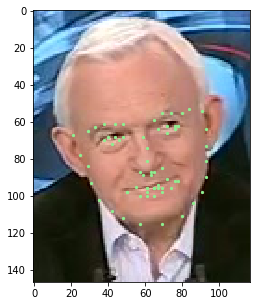

In [7]:
# select an image by index in our data frame
image_name = key_pts_frame_train.iloc[100, 0]
key_pts = key_pts_frame_train.iloc[100, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('training/', image_name)), key_pts)
plt.show()

## Creating Dict for images and their keypoints


By creating a class  We will read the CSV file in ``__init__`` but leave the reading of images to ``__getitem__``. This is memory efficient because all the images are not stored in the memory at once but read as required.



In [0]:
from torch.utils.data import Dataset

class KeypointsAndImgsDict(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):# accessing i-th of images data
        image_name = os.path.join(self.root_dir,
                                  self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
# Construct the dataset
face_dataset = KeypointsAndImgsDict(csv_file='/content/drive/My Drive/Datasets/Face key-points/training_frames_keypoints.csv',
                                      root_dir='training/')

## Transforms

the images should be of the same size, so that we could train NN on them and also should be standardized.

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``Crop``: to crop an image.


We will write them as  classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called.



In [0]:
import torch
from torchvision import transforms#Transforms are common image transformations. They can be chained together using Compose

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        if(len(image_copy.shape) == 2):
            # add that third color dim
            image_copy = image_copy.reshape(image_copy.shape[0], image_copy.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image_copy = image_copy.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image_copy),
                'keypoints': torch.from_numpy(key_pts_copy)}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class Crop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


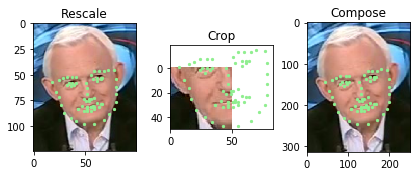

In [19]:
# test out some of these transforms
rescale = Rescale(100)
crop = Crop(50)
composed = transforms.Compose([Rescale(250)])

# apply the transforms to a sample image
sample = face_dataset[100]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

## Create the transformed dataset

Apply the transforms in order to get grayscale images of the same shape.

In [0]:
# define the data tranform
data_transform = transforms.Compose([Rescale(250),
                                     Crop(224),
                                     Normalize()])

# create the transformed dataset
transformed_dataset = KeypointsAndImgsDict(csv_file='/content/drive/My Drive/Datasets/Face key-points/training_frames_keypoints.csv',
                                             root_dir='training/',
                                             transform=data_transform)

test_dataset = KeypointsAndImgsDict(csv_file='/content/drive/My Drive/Datasets/Face key-points/test_frames_keypoints.csv',
                                             root_dir='test/',
                                             transform=data_transform)


In [21]:

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())
print(i, transformed_dataset[100]['image'].size(), transformed_dataset[100]['keypoints'].size())


0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## CNN Architecture

CNN's are defined by a few types of layers:
* four Convolutional layers
* Maxpooling layers
* three Fully-connected layers

In [0]:
##defining the convolutional neural network architecture

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I#to initialize the weights of your network
import torch.optim as optim

class FaceKeyPointsDetector(nn.Module):

    def __init__(self):

        super(FaceKeyPointsDetector, self).__init__()

        # Covolutional Layers
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 2)

        # Maxpooling Layer
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features = 36864, out_features = 1000) # The number of input gained by "print("Flatten size: ", x.shape)" in below
        self.fc2 = nn.Linear(in_features = 1000,    out_features = 1000)
        self.fc3 = nn.Linear(in_features = 1000,    out_features = 136) # the output 136 in order to having 2 for each of the 68 keypoint (x, y) pairs

        # Dropouts
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.2)
        self.drop3 = nn.Dropout(p = 0.3)
        self.drop4 = nn.Dropout(p = 0.4)
        self.drop5 = nn.Dropout(p = 0.5)
        self.drop6 = nn.Dropout(p = 0.6)




    def forward(self, x):

        # First - Convolution + Activation + Pooling + Dropout
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.drop1(x)
        #print("First size: ", x.shape)

        # Second - Convolution + Activation + Pooling + Dropout
        x = self.drop2(self.pool(F.relu(self.conv2(x))))
        #print("Second size: ", x.shape)

        # Third - Convolution + Activation + Pooling + Dropout
        x = self.drop3(self.pool(F.relu(self.conv3(x))))
        #print("Third size: ", x.shape)

        # Forth - Convolution + Activation + Pooling + Dropout
        x = self.drop4(self.pool(F.relu(self.conv4(x))))
        #print("Forth size: ", x.shape)

        # Flattening the layer
        x = x.view(x.size(0), -1)
        #print("Flatten size: ", x.shape)

        # First - Dense + Activation + Dropout
        x = self.drop5(F.relu(self.fc1(x)))
        #print("First dense size: ", x.shape)

        # Second - Dense + Activation + Dropout
        x = self.drop6(F.relu(self.fc2(x)))
        #print("Second dense size: ", x.shape)

        # Final Dense Layer
        x = self.fc3(x)
        #print("Final dense size: ", x.shape)

        return x


In [0]:
faceKeyPointsDetector = FaceKeyPointsDetector()

## shuffling data and determine batch size

In [0]:
from torch.utils.data import  DataLoader
# load training data in batches
batch_size = 10
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)#to preprocessing faster but consume more memory

# load testing data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


In [25]:
len(train_loader)

347

## Training and Initial Observation

 

In [0]:
def train_network(n_epochs):

    # prepare the network for training
    faceKeyPointsDetector.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        correct = 0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = faceKeyPointsDetector(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            
            # print loss statistics
            running_loss += loss.item()
          
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0
    return running_loss
    print('Finished Training')


In [0]:
#Adadelta 0.001 lowest acc ever
criterion = nn.MSELoss()
# L1Loss MAE

optimizer=optim.Adadelta(params=faceKeyPointsDetector.parameters(),lr=1,rho=0.9,eps=1e-06,weight_decay=0)
total_loss=train_network(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: 1, Batch: 10, Avg. Loss: 0.005925479531288147
Epoch: 1, Batch: 20, Avg. Loss: 0.004429690748453141
Epoch: 1, Batch: 30, Avg. Loss: 0.002685612738132477
Epoch: 1, Batch: 40, Avg. Loss: 0.002588890686631203
Epoch: 1, Batch: 50, Avg. Loss: 0.0027428576499223707
Epoch: 1, Batch: 60, Avg. Loss: 0.0028837090134620665
Epoch: 1, Batch: 70, Avg. Loss: 0.0020235436558723448
Epoch: 1, Batch: 80, Avg. Loss: 0.0020797196179628374
Epoch: 1, Batch: 90, Avg. Loss: 0.00222340789437294
Epoch: 1, Batch: 100, Avg. Loss: 0.0019779272228479384
Epoch: 1, Batch: 110, Avg. Loss: 0.0020617209374904633
Epoch: 1, Batch: 120, Avg. Loss: 0.0019379365891218185
Epoch: 1, Batch: 130, Avg. Loss: 0.0021920543909072876
Epoch: 1, Batch: 140, Avg. Loss: 0.0020426344275474547
Epoch: 1, Batch: 150, Avg. Loss: 0.0018523877412080765
Epoch: 1, Batch: 160, Avg. Loss: 0.0018328902274370193
Epoch: 1, Batch: 170, Avg. Loss: 0.0019283229485154152
Epoch: 1, Batch: 180, Avg. Loss: 0.0019284532070159913
Epoch: 1, Batch: 190, Avg

#Testing



In [0]:
# test the model on a batch of test images

def predict():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get network output
        output_pts = faceKeyPointsDetector(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

 
            

In [0]:
# visualize the output
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
            # image is grayscale
        plt.imshow(np.squeeze(image), cmap='gray')
        plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
        # plot ground truth points as green pts
        if ground_truth_pts is not None:
            plt.scatter(ground_truth_pts[:, 0], ground_truth_pts[:, 1], s=20, marker='.', c='g')

        plt.axis('off')

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


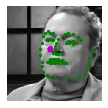

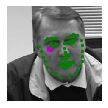

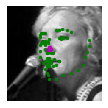

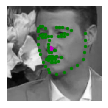

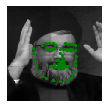

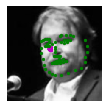

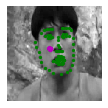

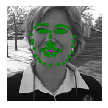

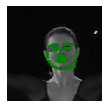

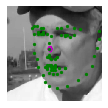

In [29]:
# get a sample of test data
test_images, test_outputs, gt_pts = predict()
visualize_output(test_images, test_outputs, gt_pts)


## Saving Model

In [0]:
# directory for saving the model
model_dir = '/content/drive/My Drive/Datasets/Face key-points/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(faceKeyPointsDetector.state_dict(), model_dir+model_name)

In [33]:
# Loading the model
faceKeyPointsDetector.load_state_dict(torch.load('/content/drive/My Drive/Datasets/Face key-points/adamDeltaLR1Batch20.pt'))

<All keys matched successfully>

## Testing on Different Data

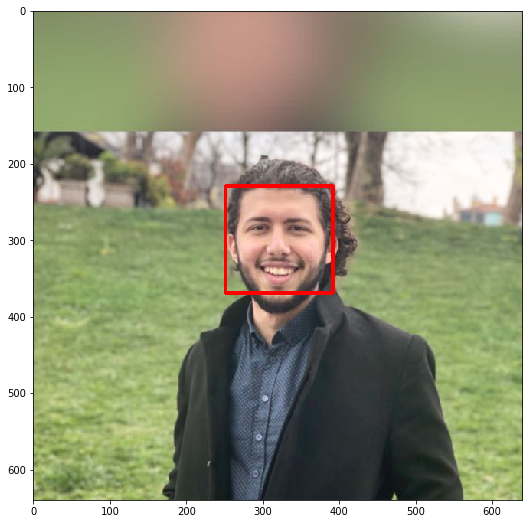

In [34]:
# load in color image for face detection
image = cv2.imread('/content/drive/My Drive/Datasets/Face key-points/pp.jpeg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Datasets/Face key-points/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [0]:
def show_all_keypoints(image, keypoints):
    """
    Visuzlizing the image and the keypoints on it.
    """
    plt.figure(figsize=(5,5))
    
    keypoints = keypoints.data.numpy()
    keypoints = keypoints * 60.0 + 96 # Becuase of normalization, keypoints won't be placed if they won't reutrn to values before noramlization 
    keypoints = np.reshape(keypoints, (68, -1)) # reshape to 2 X 68 keypoint for the fase

    image = image.numpy()   
    image = np.transpose(image, (1, 2, 0))  # Convert to numpy image shape (H x W x C)
    image = np.squeeze(image)
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=40, marker='.', c='m')

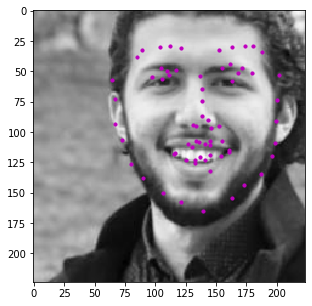

In [36]:
from torch.autograd import Variable

image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:

    # Select the region of interest that is the face in the image 
    roi = image_copy[y:y + int(1.5 * h), x - int(0.4 * w):x + int(1.1 * w)]
    #plt.imshow(roi)
    
    ##  Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    #plt.imshow(roi, cmap = 'gray')
    
    ##  Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi / 255.
    #plt.imshow(roi, cmap = 'gray')
    
    ##  Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    #plt.imshow(roi, cmap = 'gray')
    
    ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = np.expand_dims(roi, 0)
    roi = np.expand_dims(roi, 0) # (1, 1, 224, 224)
    # roi = np.reshape(roi, (1, 1, 224, 224)) # Option 2
    #print(roi.shape)

    ##  Make facial keypoint predictions using your loaded, trained network 
    ## perform a forward pass to get the predicted facial keypoints
    roi_torch = Variable(torch.from_numpy(roi)) # Converting numpy to torch variable
    #print(roi_torch.shape)
    roi_torch = roi_torch.type(torch.FloatTensor)
    keypoints = faceKeyPointsDetector(roi_torch) # Forward pass
    
    ##  Display each detected face and the corresponding keypoints        
    show_all_keypoints(roi_torch.squeeze(0), keypoints)